## Import bibliotek

In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix

## Wczytanie danych

In [36]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
column_names = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
df = pd.read_csv(url, names=column_names)

type_names = {
    1: 'building_windows_float_processed',
    2: 'building_windows_non_float_processed',
    3: 'vehicle_windows_float_processed',
    4: 'vehicle_windows_non_float_processed(none in this database)',
    5: 'containers',
    6: 'tableware',
    7: 'headlamps'
}

# Łączenie kolumny Type z TypeName
df['TypeName'] = df['Type'].map(lambda x: type_names[x].replace('_', ' ').title())

# Podział danych na cechy (X) i etykiety (Y) - potrzebne przy późniejszym podziale na zestaw uczący i walidacyjny
X = df[['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']]
Y = df['Type']

# Analiza danych

W nawiązaniu do danych:
- Id number: Numer identyfikacyjny przypisany do rekordu.

- RI refractive index: Współczynnik załamania światła. Jest to wartość numeryczna, która może przyjmować różne wartości dla różnych rodzajów szkła.

- Na, Mg, Al, Si, K, Ca, Ba, Fe: Procentowa zawartość poszczególnych pierwiastków w szkle. Są to wartości numeryczne.

- Type of glass: Rodzaj szkła, może przyjmować wartości od 1 do 7, zgodnie z opisem z pliku "glass.names".

W nawiązaniu do analizy:
- Wartości numeryczne cech mogą mieć różne zakresy i rozkłady, co może wpływać na algorytmy uczenia maszynowego.

- Cechy RI, Na, Mg, Al, Si, K, Ca, Ba i Fe reprezentują skład chemiczny szkła.

- Etykieta Type of glass jest celem predykcyjnym, którego będziemy chcieli się nauczyć przewidywać.

# Eksploracja danych

In [37]:
df

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type,TypeName
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0,1,Building Windows Float Processed
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0,1,Building Windows Float Processed
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0,1,Building Windows Float Processed
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0,1,Building Windows Float Processed
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0,1,Building Windows Float Processed
...,...,...,...,...,...,...,...,...,...,...,...,...
209,210,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0,7,Headlamps
210,211,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0,7,Headlamps
211,212,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0,7,Headlamps
212,213,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0,7,Headlamps


In [38]:
# descriptions
df.describe()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


### Rozkład cech

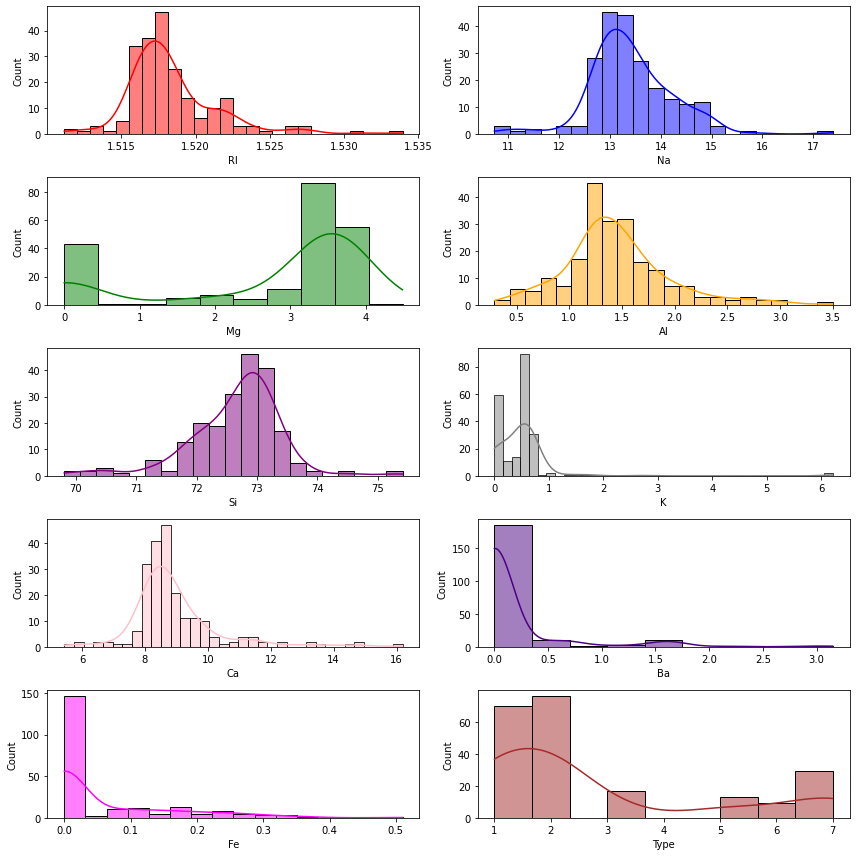

In [39]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'gray', 'pink', 'indigo', 'magenta', 'brown']

# Wykres rozkładu cech
plt.figure(figsize=(12, 12))
for i, column in enumerate(df.columns[1:]):
    if i < 10:
        plt.subplot(5, 2, i+1)
        sns.histplot(df[column], kde=True, color=colors[i])
        plt.xlabel(column)
plt.tight_layout()
plt.show()

### Wykresy pudełkowe

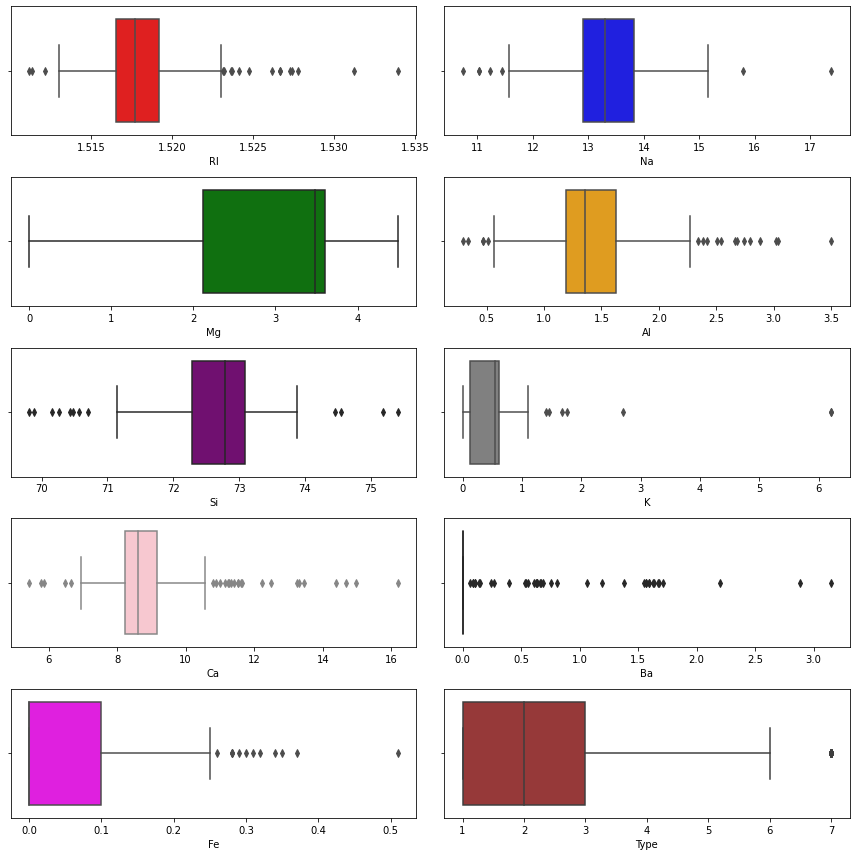

In [43]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'gray', 'pink', 'indigo', 'magenta', 'brown']
plt.figure(figsize=(12, 12))
for i, column in enumerate(df.columns[1:]):
    if i < 10:
        plt.subplot(5, 2, i+1)
        sns.boxplot(x=df[column], color=colors[i])
        plt.xlabel(column)
plt.tight_layout()
plt.show()

In [40]:
df.groupby('TypeName').size()

TypeName
Building Windows Float Processed        70
Building Windows Non Float Processed    76
Containers                              13
Headlamps                               29
Tableware                                9
Vehicle Windows Float Processed         17
dtype: int64

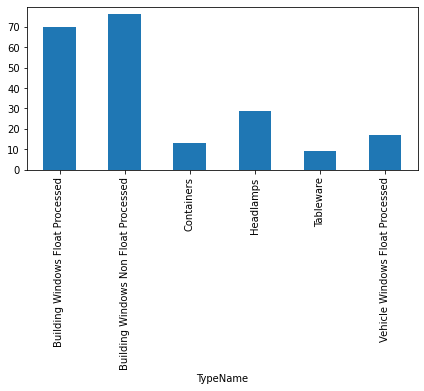

In [41]:
df.groupby('TypeName').size().plot(kind='bar', figsize=(7, 3))
plt.show()

### Macierz korelacji

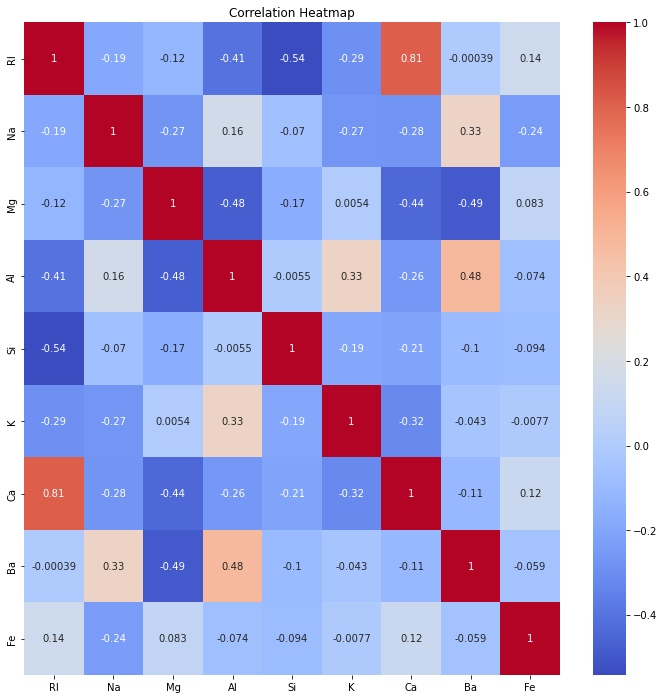

In [42]:
corel = df.drop('Id', axis=1)
corel = corel.drop('Type', axis=1).corr()

# Tworzenie heatmapy
plt.figure(figsize=(12, 12))
sns.heatmap(corel, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Wnioski

Najwięcej danych w zbiorze stanowią dane o szkle wykorzystywanym do budowy okien. Największą część składu szkła stanowią pierwiastki: krzem i sód. Można zaobserwować wysoką korelację współczynnika załamania światła oraz wapnia - możliwe, że to ten pierwiastek decyduje głównie o tym współczynniku. 

# Przygotowanie danych

## Dane bez przetworzenia

In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

## Dane ustandaryzowane

In [45]:
# Inicjalizacja obiektu skalowania
standard_scaler = StandardScaler()

# Dopasowanie skalera do danych uczących i transformacja danych
X_std_train = standard_scaler.fit_transform(X_train)
X_std_train = pd.DataFrame(X_std_train, columns=X_train.columns)

# Transformacja danych walidacyjnych
X_std_test = standard_scaler.transform(X_test)
X_std_test = pd.DataFrame(X_std_test, columns=X_test.columns)

## Dane znormalizowane

In [46]:
# Inicjalizacja obiektu normalizera
normalizer = MinMaxScaler()

# Dopasowanie normalizera do danych uczących i transformacja danych
X_norm_train = normalizer.fit_transform(X_train)
X_norm_train = pd.DataFrame(X_norm_train, columns=X_train.columns)

# Transformacja danych walidacyjnych
X_norm_test = normalizer.transform(X_test)
X_norm_test = pd.DataFrame(X_norm_test, columns=X_test.columns)

## PCA

In [49]:
# Inicjalizacja obiektu PCA wraz z liczbą komponentów
PCA_COMPONENTS = 9
pca = PCA(n_components=PCA_COMPONENTS)

# Dopasowanie do danych uczących i transformacja danych
X_pca_train = pca.fit_transform(X_train)
X_pca_train = pd.DataFrame(X_pca_train, columns=[f'PC{i}' for i in range(1, 1 + PCA_COMPONENTS)])

#Transformacja danych walidacyjnych
X_pca_test = pca.transform(X_test)
X_pca_test = pd.DataFrame(X_pca_test, columns=[f'PC{i}' for i in range(1, 1 + PCA_COMPONENTS)])

# Klasyfikacja

## Metody pomocnicze

In [131]:
def train_and_test_model(model, X_train, X_test, Y_train, Y_test):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    print("Confusion matrix:\n", confusion_matrix(Y_test, Y_pred))
    print("\nClassification report:\n", classification_report(Y_test, Y_pred))

In [132]:
def test_models(X_train, X_test, process_name):    
    classifiers = [
        ('decision_tree', DecisionTreeClassifier()),
        ('naive_bayes', GaussianNB())
    ]

    for name, model in classifiers:
        print("Preprocessing: ", process_name)
        print("Klasyfikator: ", name)
        train_and_test_model(model, X_train, X_test, Y_train, Y_test)
    print()

## Testowanie klasyfikatorów

In [133]:
test_models(X_train, X_test, "brak")
test_models(X_std_train, X_std_test, "standaryzacja")
test_models(X_norm_train, X_norm_test, "normalizacja")
test_models(X_pca_train, X_pca_test, "PCA")

Preprocessing:  brak
Klasyfikator:  decision_tree
Confusion matrix:
 [[18  1  1  0  0  1]
 [ 2 14  4  1  2  0]
 [ 2  0  3  0  0  0]
 [ 0  1  0  3  0  0]
 [ 0  1  0  0  2  0]
 [ 0  0  0  0  0  9]]

Classification report:
               precision    recall  f1-score   support

           1       0.82      0.86      0.84        21
           2       0.82      0.61      0.70        23
           3       0.38      0.60      0.46         5
           5       0.75      0.75      0.75         4
           6       0.50      0.67      0.57         3
           7       0.90      1.00      0.95         9

    accuracy                           0.75        65
   macro avg       0.69      0.75      0.71        65
weighted avg       0.78      0.75      0.76        65

Preprocessing:  brak
Klasyfikator:  naive_bayes
Confusion matrix:
 [[18  1  1  0  1  0]
 [16  3  1  0  2  1]
 [ 4  0  0  0  1  0]
 [ 0  2  0  0  0  2]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  9]]

Classification report:
               pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

Widzimy, że dla wszystkich sposobów przetworzenia danych lepsze rezultaty osiąga drzewo decyzyjne. Wynika to z tego, że naiwny klasyfikator Bayesa zakłada niezależność wszystkich cech od siebie, co w niektórych przypadkach może prowadzić do zbyt dużego uproszczenia. W naszym przypadku na macierzy korelacji widzieliśmy wyraźnie, że niektóre cechy były ze sobą skorelowane. 

Zbyt wielkich różnic dla tego klasyfikatora nie robi przetwarzanie danych poprzez standaryzację czy normalizację, ponieważ klasyfikator ten nie zależy od skali danych - bazuje jedynie na prawdopodobieństwach warunkowych między cechami a klasami. Standaryzacja lub normalizacja zmienia jedynie skalę danych, ale nie zmienia wzajemnych relacji między nimi. Zakłada on także niezależność między cechami, a przeskalowanie danych nie ma wpływu na to założenie. Jednak przetworzenie danych poprzez PCA powoduje polepszenie wyników - być może dlatego, że PCA redukuje wymiarowość danych, co może pomóc w eliminacji zbędnych informacji i szumów w danych, dzięki czemu poprawia się zdolność klasyfikatora Bayesa do identyfikacji istotnych wzorców. PCA sortuje także składowe główne według ich wariancji, co oznacza, że pierwsze składowe główne przechowują najwięcej informacji o danych. Przetworzenie danych przez PCA i wykorzystanie tylko najważniejszych składowych głównych może skoncentrować się na istotnych aspektach danych i zredukować wpływ mniej ważnych cech na wyniki klasyfikacji.

Jeśli chodzi o drzewo decyzyjne, tutaj przetworzenie parametrów poprzez standaryzację lub normalizację również nie zmienia skuteczności klasyfkacji - klasyfikator ten nie zależy od skali danych, ponieważ decyzje podejmowane są na podstawie progu podziału na poszczególnych węzłach drzewa. Standaryzacja lub normalizacja danych nie zmieniają relacji między cechami, a jedynie ich skale. Zaś przetworzenie danych przez PCA wpływa negatywnie na wyniki - prawdopodobnie dlatego, że przetworzenie danych przez PCA i wykorzystanie tylko wybranych składowych głównych może utrudnić interpretację modelu, ponieważ reguły klasyfikacyjne będą oparte na abstrakcyjnych kombinacjach składowych głównych, a nie bezpośrednio na oryginalnych cechach.

## Zmiana hiperparametrów

### Naiwny klasyfikator Bayesa

In [94]:
priors_equal = [1/len(Y.unique())] * len(Y.unique())

In [134]:
def find_best_bayes(processing, X_train, X_test, steps, min_alpha, max_alpha, priors=None):
    model = GaussianNB()
    smoothing = np.logspace(min_alpha, max_alpha, steps)
    priors_name = "Default priors" if priors is None else "Equal priors"
    best_accuracy = 0
    best_alpha = 0
    accuracies = []
    alphas = []

    for val in smoothing:
        model.set_params(var_smoothing=val, priors=priors)
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        accuracy = accuracy_score(Y_test, Y_pred)
        accuracies.append(accuracy)
        alphas.append(val)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_alpha = val


    print(f"Preprocessing: {processing}",
          f'Best accuracy: {best_accuracy:.3f}', priors_name, f'Smoothing: {best_alpha:.10f}', sep="\t")

In [138]:
find_best_bayes("Brak", X_train, X_test, 500, -5, 0)
find_best_bayes("Brak", X_train, X_test, 500, -5, 0, priors_equal)

find_best_bayes("std", X_std_train, X_std_test, 500, -10, 0)
find_best_bayes("std", X_std_train, X_std_test, 500, -10, 0, priors_equal)

find_best_bayes("norm", X_norm_train, X_norm_test, 500, -10, 0)
find_best_bayes("norm", X_norm_train, X_norm_test, 500, -10, 0, priors_equal)

find_best_bayes("PCA", X_pca_train, X_pca_test, 500, -10, 0)
find_best_bayes("PCA", X_pca_train, X_pca_test, 500, -10, 0, priors_equal)

Preprocessing: Brak	Best accuracy: 0.554	Default priors	Smoothing: 0.0140053055
Preprocessing: Brak	Best accuracy: 0.492	Equal priors	Smoothing: 0.0000100000
Preprocessing: std	Best accuracy: 0.538	Default priors	Smoothing: 0.0572156756
Preprocessing: std	Best accuracy: 0.477	Equal priors	Smoothing: 0.0000000001
Preprocessing: norm	Best accuracy: 0.569	Default priors	Smoothing: 0.0572156756
Preprocessing: norm	Best accuracy: 0.477	Equal priors	Smoothing: 0.0000000001
Preprocessing: PCA	Best accuracy: 0.600	Default priors	Smoothing: 0.0130687023
Preprocessing: PCA	Best accuracy: 0.585	Equal priors	Smoothing: 0.0000000557


Najlepsze wyniki naiwny klasyfikator Bayesa osiągnął dla przetwarzania danych metodą PCA, domyślnych wartości prawdopodobieństw (priors) oraz wartości "smoothing" ok. 0,01. Najgorsze wyniki klasyfikator ma dla danych po standaryzacji oraz normalizacji oraz równych wartości prawdopodobieństw dla każdej z klas. Modyfikacja prawdopodobieństw na równe dla każdej z klas pogarsza wynik w kazdym wariancie przetwarzania danych - jeśli klasy są nierówno reprezentowane w danych, priorytety równych prawdopodobieństw mogą prowadzić do błędnej klasyfikacji, szczególnie dla mniej licznych klas, które w źródłowym zbiorze występują. Natomiast modyfikacja parametru "smoothing" polepszyła wyniki w każdym przypadku - w niektórych przypadkach braku wystąpień pewnej kombinacji wartości cech w danych treningowych, estymacja maksymalnego prawdopodobieństwa może wynosić zero, co prowadzi do problemów w dalszej klasyfikacji. Ustawienie wartości "smoothing" większej niż zero pozwala na wygładzenie estymacji i przeciwdziałanie zerowym prawdopodobieństwom, co poprawia wyniki klasyfikacji.

## Drzewo decyzyjne

In [136]:
def find_best_tree(processing, X_train, X_test, max_depth=10, max_leaves=10, criterion="gini"):
    model = DecisionTreeClassifier()
    depths = range(2, max_depth)
    leaf_nodes = range(2, max_leaves)

    accuracies = np.array([[0] * len(leaf_nodes)] * len(depths), dtype=float)

    best_accuracy = 0
    best_depth = 0
    best_leaf_nodes = 0

    for max_depth in depths:
        for max_leaf_nodes in leaf_nodes:
            model.set_params(max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, criterion=criterion)
            model.fit(X_train, Y_train)
            Y_pred = model.predict(X_test)
            accuracy = accuracy_score(Y_test, Y_pred)
            accuracies[max_depth - 2, max_leaf_nodes - 2] = accuracy
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_depth = max_depth
                best_leaf_nodes = max_leaf_nodes

    print(f"Preprocessing: {processing}", f'Best accuracy: {best_accuracy:.5f}', f'Depth: {best_depth}', f'Leaf nodes: {best_leaf_nodes}',  f'Criterion: {criterion}', sep="\t")

In [139]:
find_best_tree("brak", X_train, X_test, 20, 20)
find_best_tree("brak", X_train, X_test, 20, 20, criterion="entropy")

find_best_tree("std", X_std_train, X_std_test, 20, 20)
find_best_tree("std", X_std_train, X_std_test, 20, 20, criterion="entropy")

find_best_tree("norm", X_norm_train, X_norm_test, 20, 20)
find_best_tree("norm", X_norm_train, X_norm_test, 20, 20, criterion="entropy")

find_best_tree("PCA", X_pca_train, X_pca_test, 20, 20)
find_best_tree("PCA", X_pca_train, X_pca_test, 20, 20, criterion="entropy")

Preprocessing: brak	Best accuracy: 0.76923	Depth: 7	Leaf nodes: 19	Criterion: gini
Preprocessing: brak	Best accuracy: 0.80000	Depth: 16	Leaf nodes: 19	Criterion: entropy
Preprocessing: std	Best accuracy: 0.76923	Depth: 11	Leaf nodes: 19	Criterion: gini
Preprocessing: std	Best accuracy: 0.80000	Depth: 8	Leaf nodes: 19	Criterion: entropy
Preprocessing: norm	Best accuracy: 0.76923	Depth: 7	Leaf nodes: 19	Criterion: gini
Preprocessing: norm	Best accuracy: 0.80000	Depth: 15	Leaf nodes: 19	Criterion: entropy
Preprocessing: PCA	Best accuracy: 0.69231	Depth: 5	Leaf nodes: 15	Criterion: gini
Preprocessing: PCA	Best accuracy: 0.72308	Depth: 4	Leaf nodes: 10	Criterion: entropy


Jak widać, modyfikacja hiperparametrów w przypadku klasyfikatora drzewa decyzyjnego znacznie polepszyła wyniki. Najgorsze rezultaty klasyfikator osiąga dla przetwarzania danych metodą PCA, jednak mimo to są one lepsze niż przy braku modyfikacji hiperparametrów. Najlepsze wyniki zostały osiągnięte dla braku przetwarzania danych oraz normalizacji. 

Modyfikacja parametrów "max_depth" oraz "max_leaf_nodes" miała pozytywny wpływ na wyniki - zmniejsza to liczbę podziałów i reguł decyzyjnych w drzewie. Dłuższe reguły decyzyjne mogą prowadzić do zbyt skomplikowanych modeli, które mogą być podatne na szum w danych treningowych lub nieistotne zależności. Poprzez ograniczenie maksymalnej głębokości drzewa, model staje się bardziej zwięzły i bardziej odporny na wpływ nieistotnych cech. 

Duży wplyw miała modyfikacja parametru "criterion", czyli miary jakości używanej do wyboru podziału w węźle drzewa. Wartość ustawiona na "entropy" w każdym przypadku poprawiała wynik. Miara "entropy" oparta na entropii informacyjnej mierzy stopień nieuporządkowania lub niejednoznaczności w zbiorze danych. W przypadku, gdy dane mają skomplikowane wzorce i wiele cech jest istotnych dla klasyfikacji, miara "entropy" może lepiej radzić sobie z identyfikacją ważnych podziałów i tworzeniem bardziej dokładnych drzew decyzyjnych. W porównaniu, miara "gini" mierzy impurity poprzez ocenę częstości występowania różnych klas, ale niekoniecznie wydobywa bardziej subtelne wzorce w danych. Miara "entropy" jest również bardziej wrażliwa na równomierną dystrybucję klas w węzłach drzewa. Przy użyciu "entropy" drzewo decyzyjne ma tendencję do równoważenia podziałów klasowych w węzłach, co może być korzystne, jeśli chcemy uniknąć dominacji jednej klasy i poprawić ogólną zdolność klasyfikatora do rozpoznawania różnych klas.